In [42]:
from scipy.io import loadmat
import tempfile
import glob
import re
import h5py
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import binary_dilation
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def copy_file_with_structure(source_path, base_destination):
    # Extract the relevant parts of the source path
    base_name = os.path.basename(source_path)  # e.g., 'SIMULATION_scan_00003_1_Trial1_groundtruth.h5'
    parent_dir = os.path.basename(os.path.dirname(source_path))  # e.g., '1'
    grandparent_dir = os.path.basename(os.path.dirname(os.path.dirname(source_path)))  # e.g., 'iGluSnFR-testing-Sim-Data_2'

    # Define the new file structure
    new_structure = os.path.join(f"{grandparent_dir}_registered", parent_dir, base_name)

    # Combine the base destination directory with the new file structure
    destination_path = os.path.join(base_destination, new_structure)

    # Create the necessary directories in the destination path
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)

    # Copy the file to the new destination
    shutil.copy2(source_path, destination_path)

    print(f"File copied to {destination_path}")

In [38]:
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import linregress

def smooth_exp(D, mode, window):
    """
    Smooth data but do a linear fit at the start to avoid issues with edge
    effects. Useful for exponential bleaching curves.
    """
    # First dimension is time
    origsz = D.shape
    D = D.reshape(D.shape[0], -1)
    window = int(min(window, D.shape[0]))  # Ensure window is an integer
    t = np.arange(1, window + 1)
    p = np.column_stack((t, np.ones_like(t)))

    # Smooth data
    if mode == 'movmean':
        sVals = uniform_filter1d(D, size=window, axis=0, mode='nearest')
    else:
        raise ValueError("Unsupported mode")

    lVals = np.full((len(t), D.shape[1]), np.nan)
    for ix in range(D.shape[1]):
        inds = np.where(~np.isnan(D[t-1, ix]))[0]
        if len(inds) > 0:
            b = linregress(inds, D[inds, ix])
            lVals[:, ix] = p @ np.array([b.slope, b.intercept])

    weights = t / len(t)
    sVals[t-1, :] = weights[:, None] * sVals[t-1, :] + (1 - weights[:, None]) * lVals

    mVals = uniform_filter1d(D[:min(len(D), 2*window), :] - sVals[:min(len(D), 2*window), :], size=window, axis=0, mode='nearest')
    sVals[:window, :] = sVals[:window, :] + mVals[:window, :]
    sVals = sVals.reshape(origsz)
    
    return sVals


In [48]:
import os
import glob
import re
import tempfile
import h5py
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader

savedr = '/root/capsule/scratch/test1/'

# Define the directory path
fns = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered/1/'

# Define the pattern to match files
pattern = os.path.join(fns, '*_Trial*.tif')

# Use glob to find all files matching the initial pattern
initial_matching_files = glob.glob(pattern)

# Define a regular expression to match files ending with 'Trial<int>.tif'
regex = re.compile(r'.*_Trial\d+\.tif$')

# Filter the files using the regular expression
strict_matching_files = [f for f in initial_matching_files if regex.match(f)]

params = {
    "tau_s": 0.027,  # time constant in seconds for glutamate channel; from Aggarwal et al 2023 Fig 5
    "sigma_px": 1.33,  # space constant in pixels
    "eventRateThresh_hz": 1/10,  # minimum event rate in Hz
    "sparseFac": 0.1,  # sparsity factor for shrinking sources in space, 0-1, higher value makes things sparser
    "nmfIter": 5,  # number of iterations of NMF refinement
    "dXY": 3,  # how large sources can be (radius), pixels
    "upsample": 3,  # how many times to upsample the imaging resolution for finding local maxima to identify sources; affects maximum source density
    "nmfBackgroundComps": 0,  # <=4, max number of background components to use for NMF. If 0, we compute F0 instead of fitting background
    "denoiseWindow_samps": 35,  # number of samples to average together for denoising
    "baselineWindow_Glu_s": 2,  # timescale for calculating F0 in glutamate channel, seconds
    "baselineWindow_Ca_s": 2  # timescale for calculating F0 in calcium channel, seconds
}

# Path to the original HDF5 file
original_gt_path = '/root/capsule/data/iGluSnFR-testing-Sim-Data_2/1/SIMULATION_scan_00003_1_Trial1_groundtruth.h5'

# Create a temporary file for the HDF5 operations
with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as temp_file:
    temp_file_path = temp_file.name

# Copy contents from the original HDF5 file to the temporary file
with h5py.File(original_gt_path, 'r') as original_gt, h5py.File(temp_file_path, 'w') as temp_gt:
    for key in original_gt.keys():
        original_gt.copy(key, temp_gt)

# Load alignment data (example)
meanIM = np.random.rand(10, 10, 10, 5)  # Example data
trialIx = 0
meanIM[:, :, :, trialIx] = np.nanmean(meanIM, axis=3)

print(f"Temporary file created at: {temp_file_path}")

# Process the TIFF files
discardFrames = [None] * len(strict_matching_files)
rawIMs = [None] * len(strict_matching_files)
for trialIx in range(len(strict_matching_files) - 1, -1, -1):
    print('Trial:', trialIx)
    fn = strict_matching_files[trialIx]

    # Load the TIFF
    IM = ScanImageTiffReader(fn)
    IM = np.array(IM.data(), dtype=np.float32).T

    meanIM = np.full((IM.shape[0], IM.shape[1], 1, len(strict_matching_files)), np.nan)

    if IM.shape[1] < 100:
        raise ValueError(f'{fn} is very short')
    
    IM = IM.reshape(IM.shape[0], IM.shape[1], 1, -1)  # deinterleave
    
    meanIM[:, :, :, trialIx] = np.nanmean(IM, axis=3)

    # Load alignment data from the temporary file
    with h5py.File(temp_file_path, 'r+') as temp_gt:
        temp_gt['aData/dsFac'] = round(len(temp_gt['aData/motionC'][()]) / len(temp_gt['aData/motionDSc'][()]))
        params['dsFac'] = temp_gt['aData/dsFac'][()]
        params['frametime'] = temp_gt['aData/frametime'][()]

        # Flatten aRankCorr
        aRankCorr_flat = np.ravel(temp_gt['aData/aRankCorr'])

        # Calculate the window size for the moving median
        window_size = int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))

        # Calculate the moving median using uniform_filter1d
        moving_median = uniform_filter1d(aRankCorr_flat, size=window_size)

        # Subtract the moving median from aRankCorr
        tmp = aRankCorr_flat - moving_median
        
        filtTmp = smooth_exp(tmp, 'movmean', np.ceil(.2/((temp_gt['aData/frametime'][()]*temp_gt['aData/dsFac'][()]))))

        # Assuming trialIx and filtTmp are defined
        discardFrames[trialIx] = binary_dilation(filtTmp < -(4 * np.std(filtTmp)), structure=np.ones(5))

        # Assuming trialIx, IM, and discardFrames are defined
        rawIMs[trialIx] = np.squeeze(IM[:,:,0,:])
        rawIMs[trialIx][:,:,discardFrames[trialIx]] = np.nan
    break

Temporary file created at: /tmp/tmpr83x0dz1.h5
Trial: 4


/tmp/ipykernel_880/129618990.py:77: RuntimeWarning: Mean of empty slice
  meanIM[:, :, :, trialIx] = np.nanmean(IM, axis=3)


NameError: name 'rawIMs' is not defined

In [47]:
discardFrames

[None,
 None,
 None,
 None,
 array([False, False, False, ..., False, False, False])]

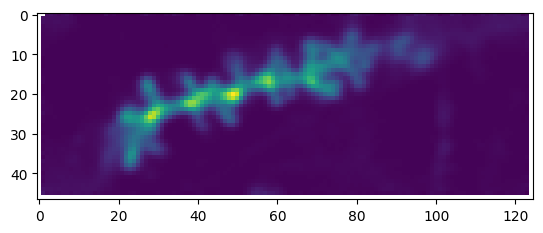

In [101]:
plt.imshow(meanIM[:,:,0,trialIx])

In [130]:
# Open the HDF5 file
gt = h5py.File('/root/capsule/data/iGluSnFR-testing-Sim-Data_2/1/SIMULATION_scan_00003_1_Trial1_groundtruth.h5', 'r')

# Access the dataset
dataset = gt['aData/motionC']

# Read the data
data = dataset[()]

# Don't forget to close the file when you're done
# gt.close()

In [121]:
a = gt['aData']
a['motionC']

<HDF5 dataset "motionC": shape (10000,), type "<f8">

In [133]:
gt['aData'].keys()

<KeysViewHDF5 ['aError', 'aRankCorr', 'frametime', 'motionC', 'motionDSc', 'motionDSr', 'motionR', 'numChannels']>

In [1]:
import tempfile
tempfile.gettempdir()

'/tmp'